In [1]:
%load_ext autoreload
%autoreload 2
import train_renderer
from Renderer.fast_stroke_gen import *
from Renderer.model import FCN

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import itertools
import scipy.signal

In [2]:
device = torch.device("cuda")
batch_size = 256
gen = FastStrokeGenerator(batch_size, width=128).to(device)
criterion = nn.MSELoss()

In [3]:
def load_model(fpath):
    net = FCN()
    train_renderer.load_weights(net, fpath)
    return net

def test_model(net, strokes, target):
    net.eval()
    with torch.no_grad():
        output = net(strokes)
        loss = criterion(output, target)
    return loss, output

In [5]:
baseline = load_model('models_renderer/renderer.pkl').to(device)

In [25]:
test = load_model('models_renderer/full_divide_gpu/model.pkl').to(device)

In [26]:
strokes = gen.generate_strokes().to(device)
target = gen(strokes)

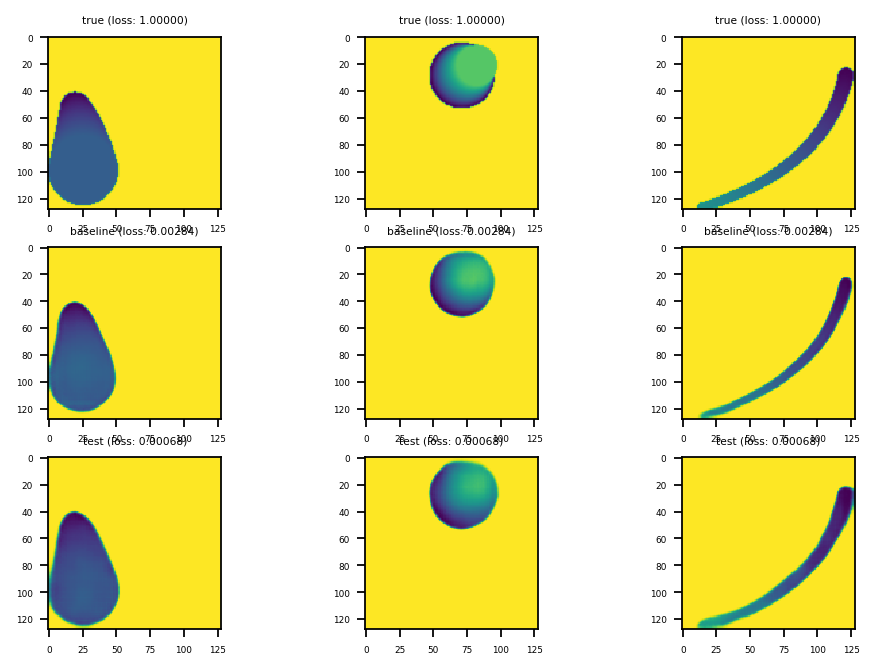

In [27]:
baseline_acc, baseline_output = test_model(baseline, strokes, target)
test_acc, test_output = test_model(test, strokes, target)
num_plot = 3
fig, axes = plt.subplots(3,num_plot, dpi=160)
plt.rcParams.update({'font.size': 4})
plt.tight_layout()
rand_selection = np.random.randint(0, batch_size, (num_plot,))
for i, j in itertools.product(range(3), range(num_plot)):
    if i == 0:
        acc = 1
        output = target
        name = "true"
    elif i == 1:
        acc = baseline_acc
        output = baseline_output
        name = "baseline"
    elif i == 2:
        acc = test_acc
        output = test_output
        name = "test"
    ax = axes[i, j]
    ax.set_title(f"{name} (loss: {acc:1.5f})")
    ax.imshow(output[rand_selection[j]].cpu())
plt.show()
    